In [193]:

import requests
from bs4 import BeautifulSoup
from itertools import combinations
import quandl
from datetime import datetime
import statsmodels.api as stats
from statsmodels.api import tsa as ts
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

In [194]:
quandl.ApiConfig.api_key = "eZ6pXoKsokxGkZNt2Swq"


def normalize_and_accumulate_series(data):
    # take tail to drop head NA
    return data.pct_change().cumsum()

def corr(data1, data2):
    # data1 & data2 should be numpy arrays.
    mean1 = data1.mean() 
    mean2 = data2.mean()
    std1 = data1.std()
    std2 = data2.std()
    corr = ((data1*data2).mean()-mean1*mean2)/(std1*std2)
    return corr 

def cointegrate_and_corrolate(indexpairs):
    for j in range(len(indexpairs)):    # clean up here
        
        closeData0 = quandl.get("WIKI/" + indexpairs[j][0], start_date = datetime(2017, 1, 1), end_date = datetime(2017,5,5))['Adj. Close']
        closeData1 = quandl.get("WIKI/" + indexpairs[j][1], start_date = datetime(2017, 1, 1), end_date = datetime(2017,5,5))['Adj. Close']
        thepair = '/'.join([indexpairs[j][0] , indexpairs[j][1]])


        dataForOne = {'Index': thepair, 'Adj. Close 0': closeData0, 'Adj. Close 1': closeData1}

        dataForOneDF = pd.DataFrame(dataForOne)
        dataForOneDF['Adj. Close 0'] = normalize_and_accumulate_series(dataForOneDF['Adj. Close 0'])
        dataForOneDF['Adj. Close 1'] = normalize_and_accumulate_series(dataForOneDF['Adj. Close 1'])
        dataForOneDF = dataForOneDF.tail(len(dataForOneDF)-1)
        coint = ts.stattools.coint(dataForOneDF['Adj. Close 0'], dataForOneDF['Adj. Close 1'])[1]
        correlation = corr(dataForOneDF['Adj. Close 0'], dataForOneDF['Adj. Close 1'])
        
        # Dataframe of the coint and corr outputs for each pair 
        dictDF = pd.DataFrame({'Index Pair': [thepair], 'Cointegration Pvalue': coint, 'Correlation Value': abs(correlation)})
        # Dataframe compiling all coint and corr outputs for all index pairs
        cointDF = pd.DataFrame()
        cointDF = cointDF.append(dictDF, ignore_index = True)
        # Finding the best performers and putting them in the same list
        top10coint = cointDF.nsmallest(10, 'Cointegration Pvalue')
        top10corr = cointDF.nlargest(10, 'Correlation Value')
        allTop = pd.merge(top10coint, top10corr)
        return allTop
        

In [195]:
# Scraping the data from wikipedia

url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#S&P_500_component_stocks'
page = requests.get(url)

theSOUP = BeautifulSoup(page.content, 'html.parser')

results = theSOUP.find_all('a', class_='external text')
list1 = []
list2 = []
for result in results:
    
    list1.append(result.text)

for i in list1:
    if len(i) <= 5:
        list2.append(i)

In [196]:
# Naively picking random indexes

np.random.shuffle(list2)
randselected = list2[0:100]



In [197]:

FULLADFdf = pd.DataFrame()
cointDF = pd.DataFrame()
pass1 = []
    
for k in range(len(randselected)):
    try:
        data1 = quandl.get("WIKI/" + randselected[k], start_date = datetime(2017, 1, 1), end_date = datetime(2017,5,5))['Adj. Close']

        adftest1 = ts.stattools.adfuller(data1, 1)
        # Testing the adf for the set criteria

        if adftest1[1] < adftest1[4]['10%'] or adftest1[1] < (abs(adftest1[4]['10%']) and adftest1[0] < -3.5):
            pass1.append(randselected[k])
    except:
        pass
print(pass1)

['HST']


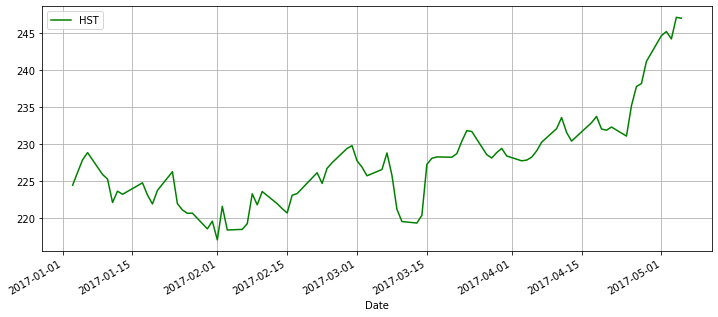

In [198]:
FULLADFdf = pd.DataFrame()
if len(pass1) > 2:
    pairedIndexes = list(combinations(pass1, 2))
    best = cointegrate_and_corrolate(pairedIndexes)

    for k in range(len(best["Index Pair"])):
        
        pairlist = best['Index Pair'].iloc[k]
        pairlist = pairlist.split("/")
        data1 = quandl.get("WIKI/" + pairlist[0], start_date = datetime(2017, 1, 1), end_date = datetime(2017,5,5))['Adj. Close']
        data2 = quandl.get("WIKI/" + pairlist[1], start_date = datetime(2017, 1, 1), end_date = datetime(2017,5,5))['Adj. Close']
        
        plt.figure(figsize=(12,5))
        
        ax1 = data1.plot(color='green', grid=True, label=pairlist[0])
        ax2 = data2.plot(color='purple', grid=True, secondary_y=True, label=pairlist[1])
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        plt.legend(h1+h2, l1+l2, loc=2)
        plt.show()
        
        subdata = ts.stattools.OLS(data1, data2).fit()
        opvalues = ts.stattools.adfuller(subdata.resid, 1)
        
        #subplot = subdata.plot(color='green', grid=True, label="OLS")
        #sub_h1, sub_l1 = ax1.get_legend_handles_labels()
        #plt.legend(sub_h1, sub_l1, loc=2)


        if opvalues[1] < opvalues[4]['10%'] or opvalues[0] < -3.5 and opvalues[1] < abs(opvalues[4]['10%']):
            answer = "Stationary"
        elif opvalues[1] < opvalues[4]['10%'] or opvalues[0] < -3.0 and opvalues[1] < abs(opvalues[4]['10%']):
            answer = "Mildly Stationary"
        else:
            answer = "Non-Stationary"

        ADFdata = {'Company Pair': [best['Index Pair'].iloc[k]],
                'ADF': [opvalues[0]],
                'Pvalue': [opvalues[1]],
        #       'Used Lag': [opvalues[2]],
        #       'NOBs': [opvalues[3]],
                'Critical Values at 1%': [opvalues[4]['1%']],
                'Critical Values at 5%': [opvalues[4]['5%']],
                'Critical Values at 10%': [opvalues[4]['10%']],
        #        'Maximized Information Criterion': [opvalues[5]],
                'Hypothesis': answer
                }

        ADFdf = pd.DataFrame(ADFdata)
        FULLADFdf = FULLADFdf.append(ADFdf, ignore_index = True)
    

elif len(pass1) == 1:
     
    testdata1 = quandl.get("WIKI/" + pass1[0], start_date = datetime(2017, 1, 1), end_date = datetime(2017,5,5))['Adj. Close']
    plt.figure(figsize=(12,5))
        
    ax1 = data1.plot(color='green', grid=True, label=pass1[0])
    h1, l1 = ax1.get_legend_handles_labels()
    plt.legend(h1, l1, loc=2)
    plt.show()

    testadftest1 = ts.stattools.adfuller(testdata1, 1)
    ADFdata = {'Company Pair': pass1,
                'ADF': [testadftest1[0]],
                'Pvalue': [testadftest1[1]],
        #       'Used Lag': [opvalues[2]],
        #       'NOBs': [opvalues[3]],
                'Critical Values at 1%': [testadftest1[4]['1%']],
                'Critical Values at 5%': [testadftest1[4]['5%']],
                'Critical Values at 10%': [testadftest1[4]['10%']],
        #        'Maximized Information Criterion': [opvalues[5]],
                'Hypothesis': 'Stationary'
                }
    ADFdf = pd.DataFrame(ADFdata)
    ADFdf
else:
    print('There were no stationary indexes found.')




In [199]:
ADFdf

,Company Pair,ADF,Pvalue,Critical Values at 1%,Critical Values at 5%,Critical Values at 10%,Hypothesis
0,HST,-3.64165,0.005013,-3.509736,-2.896195,-2.585258,Stationary
